## Basic Import

In [32]:
import argparse
import itertools
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torchvision
import torchvision.models as models
import pandas as pd

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-15 08:33:02.347150: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 08:33:02.444882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 08:33:02.883352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 08:33:02.883378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cu

### Device

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [15]:
# Set experiment parameters
alphas = [0.1, 0.05, 0.025] #0.01
num_trials = 10
NUM_EPOCHS = 50
predictors = ["SplitPredictor", "ClusterPredictor", "ClassWisePredictor"]
scores = ["THR", "APS","RAPS", "SAPS"]
weight_selections = [0.2,0.5,0.7,1,2]
alphas = [0.025,0.05,0.1]
weight = 0.2

## Data Loder

#### CIFAR10

In [16]:
# Define the CIFAR-100 dataset and transform
transform_cifar = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size for CIFAR-100
    transforms.ToTensor(),
])

dataset_cifar = CIFAR10(root='./dataset', download=True, train=True, transform=transform_cifar)

# Split dataset
train_size_cifar = int(0.8 * len(dataset_cifar))
cal_size_cifar = int(0.1 * len(dataset_cifar))
test_size_cifar = len(dataset_cifar) - train_size_cifar - cal_size_cifar

train_dataset_cifar, cal_dataset_cifar, test_dataset_cifar = random_split(
    dataset_cifar, [train_size_cifar, cal_size_cifar, test_size_cifar]
)

# Set loaders for CIFAR-10
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=512, shuffle=True, pin_memory=True)
cal_loader_cifar = DataLoader(cal_dataset_cifar, batch_size=1600, shuffle=False, pin_memory=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=1600, shuffle=False, pin_memory=True)

Files already downloaded and verified


## Model

In [17]:
# Define ResNet models
resnet18 = models.resnet18(num_classes=100)
resnet50 = models.resnet50(num_classes=100)

## Training

In [18]:
def train(model):
    for epoch in range(NUM_EPOCHS):
        model.train()
        for images, labels in train_loader_cifar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_cifar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    acc =corrects / total
    print(f"Accuracy on CIFAR10: {acc * 100:.4f}%")

## Conformal Prediction

In [19]:
def c_prediction(model,score_function, predictor_type,test_data_loader,cal_data_loader,alpha):
    model.eval()
    if score_function == "THR":
        score_function = THR()
    elif score_function == "APS":
        score_function = APS()
    elif score_function == "RAPS":
        score_function = RAPS(1, 0)
    elif score_function == "SAPS":
        score_function = SAPS(weight)
    
    if predictor_type == "SplitPredictor":
        predictor = SplitPredictor(score_function, model)
    elif predictor_type == "ClusterPredictor":
        predictor = ClusterPredictor(score_function, model)
    elif predictor_type == "ClassWisePredictor":
        predictor = ClassWisePredictor(score_function, model)
    else:
        raise NotImplementedError
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    return result['Coverage_rate'],result['Average_size']

## Results

#### ResNet18

In [20]:
criterion = nn.CrossEntropyLoss()
resnet18.to(device)
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
train(resnet18)

Accuracy on CIFAR10: 71.4200%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [21]:
weight = 0.2
resnet18_results = pd.DataFrame([
    {
        "Predictor": predictor,
        "Score Function": score_function,
        "Coverage Rate": c_prediction(resnet18, score_function, predictor, test_loader_cifar, cal_loader_cifar, alpha=0.05)[0],
        "Average Size": c_prediction(resnet18, score_function, predictor, test_loader_cifar, cal_loader_cifar, alpha=0.05)[1],
    }
    for predictor in predictors
    for score_function in scores
])
resnet18_results

/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


,Predictor,Score Function,Coverage Rate,Average Size
0,SplitPredictor,THR,0.9474,3.1100
1,SplitPredictor,APS,0.9510,8.8372
2,SplitPredictor,RAPS,0.9446,3.3672
3,SplitPredictor,SAPS,0.9452,3.5662
4,ClusterPredictor,THR,0.9464,3.1818
5,ClusterPredictor,APS,0.9534,9.2834
6,ClusterPredictor,RAPS,0.9470,3.3742
7,ClusterPredictor,SAPS,0.9486,3.5368
8,ClassWisePredictor,THR,0.9458,92.8838
9,ClassWisePredictor,APS,0.9472,93.1638


#### Compare with different weight on SAPS(alpha=0.05)

In [22]:
resnet18_SAPS_weight = pd.DataFrame([
    {
        "Predictor": predictor,
        "weight": weight,
        "Coverage Rate": c_prediction(resnet18, "SAPS", predictor, test_loader_cifar, cal_loader_cifar, alpha=0.05)[0],
        "Average Size": c_prediction(resnet18, "SAPS", predictor, test_loader_cifar, cal_loader_cifar, alpha=0.05)[1],
    }
    for predictor in predictors
    for weight in weight_selections
])
resnet18_SAPS_weight

/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


,Predictor,weight,Coverage Rate,Average Size
0,SplitPredictor,0.2,0.9472,3.5054
1,SplitPredictor,0.5,0.9482,3.5134
2,SplitPredictor,0.7,0.9480,3.6028
3,SplitPredictor,1.0,0.9474,3.5674
4,SplitPredictor,2.0,0.9436,3.5760
5,ClusterPredictor,0.2,0.9450,3.5084
6,ClusterPredictor,0.5,0.9410,3.5904
7,ClusterPredictor,0.7,0.9468,3.5760
8,ClusterPredictor,1.0,0.9462,3.4800
9,ClusterPredictor,2.0,0.9456,3.5004


#### Compare with different alpha (predictor=SplitPredictor)

In [24]:
weight = 0.2
resnet18_alpha = pd.DataFrame([
    {
        "Score Function": score_function,
        "Alpha": alpha,
        "Coverage Rate": c_prediction(resnet18,score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha)[0],
        "Average Size": c_prediction(resnet18, score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha)[1],
    }
    for alpha in alphas
    for score_function in scores
])
resnet18_alpha

,Score Function,Alpha,Coverage Rate,Average Size
0,THR,0.025,0.9724,6.7748
1,APS,0.025,0.9734,19.0410
2,RAPS,0.025,0.9688,4.5374
3,SAPS,0.025,0.9712,4.7434
4,THR,0.050,0.9474,3.1100
5,APS,0.050,0.9490,8.6026
6,RAPS,0.050,0.9458,3.3718
7,SAPS,0.050,0.9450,3.6216
8,THR,0.100,0.8906,1.9454
9,APS,0.100,0.8918,2.5392


### ResNet50

In [27]:
ResNet50_model = resnet50.to(device)
optimizer = optim.Adam(ResNet50_model.parameters(), lr=0.001)
train(ResNet50_model)

Accuracy on CIFAR10: 66.9600%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [29]:
resnet50_results = pd.DataFrame([
    {
        "Score Function": score_function,
        "Coverage Rate": c_prediction(resnet50,score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha=0.05)[0],
        "Average Size": c_prediction(resnet50,score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha=0.05)[1],
    }
    for score_function in scores
])
resnet50_results

,Score Function,Coverage Rate,Average Size
0,THR,0.9514,3.9760
1,APS,0.9494,10.8774
2,RAPS,0.9480,4.1892
3,SAPS,0.9532,4.2866


### Simple CNN

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Adjust the convolutional layers for CIFAR-10 (3 input channels)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Adjust the fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 512)  # CIFAR-10 images are 32x32
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 8 * 8)  # Adjusted for CIFAR-10
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
CNN_model = SimpleCNN().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)
train(CNN_model)

Accuracy on CIFAR10: 68.6800%


#### Compare with different score functions and predictors(weight of SAPS=0.2,alpha=0.05)

In [36]:
CNN_results = pd.DataFrame([
    {
        "Score Function": score_function,
        "Coverage Rate": c_prediction(CNN_model,score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha=0.05)[0],
        "Average Size": c_prediction(CNN_model,score_function, "SplitPredictor",test_loader_cifar,cal_loader_cifar,alpha=0.05)[1],
    }
    for score_function in scores
])
CNN_results

,Score Function,Coverage Rate,Average Size
0,THR,0.9460,3.1292
1,APS,0.9458,3.1928
2,RAPS,0.9450,4.0038
3,SAPS,0.9428,3.7918


### Visulization

#### Comparison of score functions and predictors

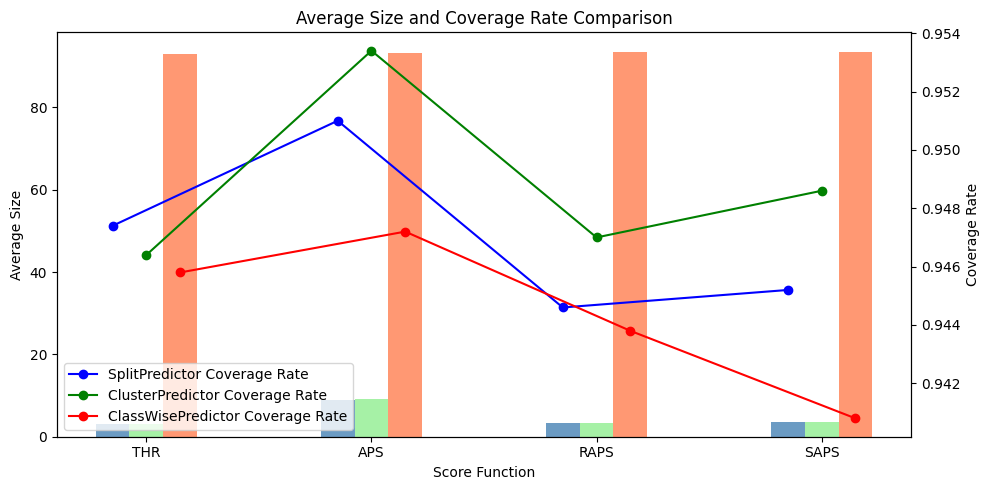

In [38]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))
bar_width = 0.15
opacity = 0.8

# Define colors for bar charts
bar_colors = {'SplitPredictor': 'steelblue', 'ClusterPredictor': 'lightgreen', 'ClassWisePredictor': 'coral'}

# Plot bar charts for Average Size
for i, predictor in enumerate(predictors):
    subset = resnet18_results[resnet18_results["Predictor"] == predictor]
    ax1.bar(
        [val + i * bar_width for val in range(len(scores))],
        subset["Average Size"],
        bar_width,
        alpha=opacity,
        label=f'{predictor} Average Size',
        color=bar_colors[predictor]
    )

ax1.set_xlabel('Score Function')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(predictors) - 1) * 0.5 * bar_width for val in range(len(scores))])
ax1.set_xticklabels(scores)
ax1.legend()
# Create a second y-axis for Coverage Rate
ax2 = ax1.twinx()
lines = []
# Define colors for line charts
line_colors = {'SplitPredictor': 'blue', 'ClusterPredictor': 'green', 'ClassWisePredictor': 'red'}

# Plot line charts for Coverage Rate
for i, predictor in enumerate(predictors):
    subset = resnet18_results[resnet18_results["Predictor"] == predictor]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(scores))],
        subset["Coverage Rate"],
        marker='o',
        linestyle='-',
        label=f'{predictor} Coverage Rate',
        color=line_colors[predictor]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', colors='black')

# Combine legends and move to the upper left
ax1.legend(lines, [line.get_label() for line in lines], loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

#### Comparison of predictors and weights on SAPS

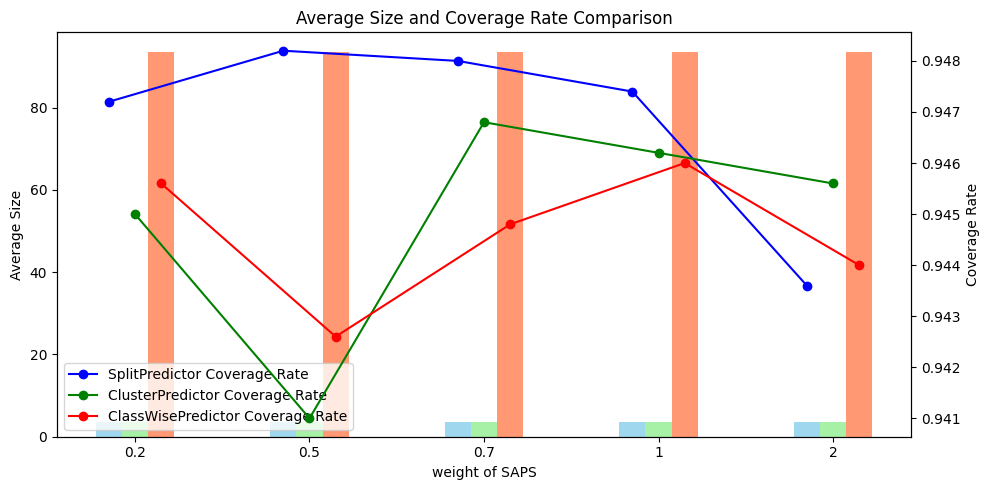

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 5))
bar_width = 0.15
opacity = 0.8

# Define colors for bar charts
bar_colors = {'SplitPredictor': 'skyblue', 'ClusterPredictor': 'lightgreen', 'ClassWisePredictor': 'coral'}

for i, predictor in enumerate(predictors):
    subset = resnet18_SAPS_weight[resnet18_SAPS_weight["Predictor"] == predictor]
    ax1.bar(
        [val + i * bar_width for val in range(len(weight_selections))],
        subset["Average Size"],
        bar_width,
        alpha=opacity,
        label=f'{predictor} Average Size',
        color=bar_colors[predictor]
    )

ax1.set_xlabel('weight of SAPS')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(predictors) - 1) * 0.5 * bar_width for val in range(len(weight_selections))])
ax1.set_xticklabels(weight_selections)
ax1.legend()
# Create a second y-axis for Coverage Rate
ax2 = ax1.twinx()
lines = []
# Define colors for line charts
line_colors = {'SplitPredictor': 'blue', 'ClusterPredictor': 'green', 'ClassWisePredictor': 'red'}

# Plot line charts for Coverage Rate
for i, predictor in enumerate(predictors):
    subset = resnet18_SAPS_weight[resnet18_SAPS_weight["Predictor"] == predictor]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(weight_selections))],
        subset["Coverage Rate"],
        marker='o',
        linestyle='-',
        label=f'{predictor} Coverage Rate',
        color=line_colors[predictor]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', colors='black')

# Combine legends and move to the upper left
ax1.legend(lines, [line.get_label() for line in lines], loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

#### Comparison of different models(SplitPredictor,alpha=0.05,weight=0.2)

In [49]:
resnet18_results1 = resnet18_results[resnet18_results['Predictor'] == "SplitPredictor"].copy().drop(columns=['Predictor'])
resnet18_results1['Source'] = 'ResNet18'
resnet50_results['Source'] = 'ResNet50'
CNN_results['Source'] = 'SimpleCNN'
result_concatenated = pd.concat([resnet18_results1, resnet50_results, CNN_results])
result_concatenated.reset_index(drop=True, inplace=True)
result_concatenated

,Score Function,Coverage Rate,Average Size,Source
0,THR,0.9474,3.1100,ResNet18
1,APS,0.9510,8.8372,ResNet18
2,RAPS,0.9446,3.3672,ResNet18
3,SAPS,0.9452,3.5662,ResNet18
4,THR,0.9514,3.9760,ResNet50
5,APS,0.9494,10.8774,ResNet50
6,RAPS,0.9480,4.1892,ResNet50
7,SAPS,0.9532,4.2866,ResNet50
8,THR,0.9460,3.1292,SimpleCNN
9,APS,0.9458,3.1928,SimpleCNN


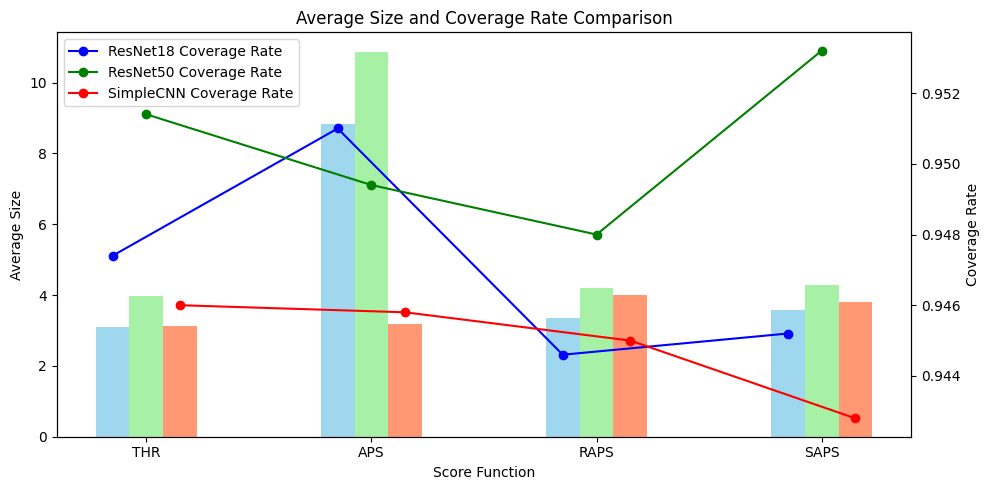

In [50]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 定义颜色
colors = {'ResNet18': 'skyblue', 'ResNet50': 'lightgreen', 'SimpleCNN': 'coral'}

# 绘制条形图（Average Size）
bar_width = 0.15
opacity = 0.8
for i, source in enumerate(result_concatenated['Source'].unique()):
    subset = result_concatenated[result_concatenated['Source'] == source]
    ax1.bar(
        [val + i * bar_width for val in range(len(subset['Score Function']))],
        subset['Average Size'],
        bar_width,
        alpha=opacity,
        label=f'{source} Average Size',
        color=colors[source]
    )

ax1.set_xlabel('Score Function')
ax1.set_ylabel('Average Size')
ax1.set_title('Average Size and Coverage Rate Comparison')
ax1.set_xticks([val + (len(result_concatenated['Source'].unique()) - 1) * 0.5 * bar_width for val in range(len(result_concatenated['Score Function']))])
ax1.set_xticklabels(result_concatenated['Score Function'])
ax1.legend(loc='upper left')

# 创建第二个y轴
ax2 = ax1.twinx()
lines = []
line_colors = {'ResNet18': 'blue', 'ResNet50': 'green', 'SimpleCNN': 'red'}
for i, source in enumerate(result_concatenated['Source'].unique()):
    subset = result_concatenated[result_concatenated['Source'] == source]
    line = ax2.plot(
        [val + i * bar_width for val in range(len(subset['Score Function']))],
        subset['Coverage Rate'],
        marker='o',
        linestyle='-',
        label=f'{source} Coverage Rate',
        color=line_colors[source]
    )[0]
    lines.append(line)

ax2.set_ylabel('Coverage Rate', color='black')
ax2.tick_params('y', color='black')

# 合并图例，并左移1cm
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left', bbox_to_anchor=(0, 1.0))

plt.tight_layout()
plt.show()